In [1]:
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Convert Images in directory into Dataset
we can use `tf.keras.preprocessing.image_dataset_from_directory` to convert the data into dataset so we can train the models out of the box

In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset",
    shuffle=True,
    batch_size=32,
    image_size=(299, 299),
)

labels = dataset.class_names
labels

Found 6900 files belonging to 80 classes.


['Aloevera',
 'Amla',
 'Amruthaballi',
 'Arali',
 'Astma_weed',
 'Badipala',
 'Balloon_Vine',
 'Bamboo',
 'Beans',
 'Betel',
 'Bhrami',
 'Bringaraja',
 'Caricature',
 'Castor',
 'Catharanthus',
 'Chakte',
 'Chilly',
 'Citron lime (herelikai)',
 'Coffee',
 'Common rue(naagdalli)',
 'Coriender',
 'Curry',
 'Doddpathre',
 'Drumstick',
 'Ekka',
 'Eucalyptus',
 'Ganigale',
 'Ganike',
 'Gasagase',
 'Ginger',
 'Globe Amarnath',
 'Guava',
 'Henna',
 'Hibiscus',
 'Honge',
 'Insulin',
 'Jackfruit',
 'Jasmine',
 'Kambajala',
 'Kasambruga',
 'Kohlrabi',
 'Lantana',
 'Lemon',
 'Lemongrass',
 'Malabar_Nut',
 'Malabar_Spinach',
 'Mango',
 'Marigold',
 'Mint',
 'Neem',
 'Nelavembu',
 'Nerale',
 'Nooni',
 'Onion',
 'Padri',
 'Palak(Spinach)',
 'Papaya',
 'Parijatha',
 'Pea',
 'Pepper',
 'Pomoegranate',
 'Pumpkin',
 'Raddish',
 'Rose',
 'Sampige',
 'Sapota',
 'Seethaashoka',
 'Seethapala',
 'Spinach1',
 'Tamarind',
 'Taro',
 'Tecoma',
 'Thumbe',
 'Tomato',
 'Tulsi',
 'Turmeric',
 'ashoka',
 'camphor',
 

In [3]:
import numpy as np

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    break

(32, 299, 299, 3)
[56 57 51  0 70 45  5 70 56 20 19  4 34 29 14 67 74 33  9  3 25 69 69 68
 47  0 25 69 60 55 14 55]


In [4]:
# train test split
train_size = int(0.8 * len(dataset))
test_size = int(0.2 * len(dataset))
train_size, test_size

(172, 43)

## Train, Test, Validate
partition the data into train test and validation datasets

In [5]:
def get_dataset_partisions_tf(ds, train_split=0.8, test_split=0.2, shuffle=True, shuffle_size=10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * len(ds))
    test_size = int(test_split * len(ds))
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size)
    val_ds = test_ds.skip(test_size)
    test_ds = test_ds.take(test_size)
    return train_ds, test_ds, val_ds

In [6]:
train_ds, test_ds, val_ds = get_dataset_partisions_tf(dataset)
len(train_ds), len(test_ds), len(val_ds)

(172, 43, 1)

## Resize and Normalize
- Xception models takes the image input as 299x299 pixels so converting into the trainable format is necessary
- The Images are to be normalized before to train accurately and efficiently

In [7]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(299, 299),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

### Download the Xception model predefined weights from tensorflow into your working environment

In [8]:
# train using Xception
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    input_shape=(299, 299, 3),
    include_top=False,
    pooling='avg',
    classifier_activation='softmax',
    classes=len(labels)
)

83683744/83683744 [==============================] - 0s 0us/step


In [9]:
base_model.trainable = False

inputs = tf.keras.Input(shape=(299, 299, 3))
x = resize_and_rescale(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(labels), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=25
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                10320     
                                                                 
Total params: 21,134,072
Trainable params: 272,592
Non-traina

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - ETA: 0s - loss: 3.2983 - accuracy: 0.2431

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 505s 1s/step - loss: 3.2983 - accuracy: 0.2431 - val_loss: 2.4025 - val_accuracy: 0.4688
Epoch 2/25


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - ETA: 0s - loss: 1.9055 - accuracy: 0.5224

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 512s 2s/step - loss: 1.9055 - accuracy: 0.5224 - val_loss: 1.4044 - val_accuracy: 0.6250
Epoch 3/25


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - ETA: 0s - loss: 1.3483 - accuracy: 0.6540

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 482s 1s/step - loss: 1.3483 - accuracy: 0.6540 - val_loss: 0.6781 - val_accuracy: 0.8750
Epoch 4/25


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - ETA: 0s - loss: 1.0454 - accuracy: 0.7240

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 478s 1s/step - loss: 1.0454 - accuracy: 0.7240 - val_loss: 0.7287 - val_accuracy: 0.8750
Epoch 5/25


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - ETA: 0s - loss: 0.8437 - accuracy: 0.7779

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 482s 1s/step - loss: 0.8437 - accuracy: 0.7779 - val_loss: 0.4501 - val_accuracy: 0.9062
Epoch 6/25


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - ETA: 0s - loss: 0.6988 - accuracy: 0.8190

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 477s 1s/step - loss: 0.6988 - accuracy: 0.8190 - val_loss: 0.4640 - val_accuracy: 0.9688
Epoch 7/25


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - ETA: 0s - loss: 0.5916 - accuracy: 0.8474

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 477s 1s/step - loss: 0.5916 - accuracy: 0.8474 - val_loss: 0.2070 - val_accuracy: 1.0000
Epoch 8/25


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - ETA: 0s - loss: 0.5072 - accuracy: 0.8671

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 480s 1s/step - loss: 0.5072 - accuracy: 0.8671 - val_loss: 0.2206 - val_accuracy: 0.9688
Epoch 9/25


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - ETA: 0s - loss: 0.4384 - accuracy: 0.8895

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 465s 1s/step - loss: 0.4384 - accuracy: 0.8895 - val_loss: 0.1086 - val_accuracy: 1.0000
Epoch 10/25


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - ETA: 0s - loss: 0.3739 - accuracy: 0.9102

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 474s 1s/step - loss: 0.3739 - accuracy: 0.9102 - val_loss: 0.1462 - val_accuracy: 1.0000
Epoch 11/25


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - ETA: 0s - loss: 0.3458 - accuracy: 0.9139

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 511s 2s/step - loss: 0.3458 - accuracy: 0.9139 - val_loss: 0.2126 - val_accuracy: 0.9688
Epoch 12/25


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - ETA: 0s - loss: 0.2974 - accuracy: 0.9253

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 472s 1s/step - loss: 0.2974 - accuracy: 0.9253 - val_loss: 0.1037 - val_accuracy: 1.0000
Epoch 13/25


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - ETA: 0s - loss: 0.2607 - accuracy: 0.9337

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 512s 2s/step - loss: 0.2607 - accuracy: 0.9337 - val_loss: 0.0863 - val_accuracy: 1.0000
Epoch 14/25


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - ETA: 0s - loss: 0.2405 - accuracy: 0.9437

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 480s 1s/step - loss: 0.2405 - accuracy: 0.9437 - val_loss: 0.1252 - val_accuracy: 1.0000
Epoch 15/25


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - ETA: 0s - loss: 0.2037 - accuracy: 0.9530

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 478s 1s/step - loss: 0.2037 - accuracy: 0.9530 - val_loss: 0.0535 - val_accuracy: 1.0000
Epoch 16/25


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - ETA: 0s - loss: 0.1826 - accuracy: 0.9576

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 477s 1s/step - loss: 0.1826 - accuracy: 0.9576 - val_loss: 0.0370 - val_accuracy: 1.0000
Epoch 17/25


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - ETA: 0s - loss: 0.1761 - accuracy: 0.9578

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 468s 1s/step - loss: 0.1761 - accuracy: 0.9578 - val_loss: 0.0825 - val_accuracy: 0.9688
Epoch 18/25


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - ETA: 0s - loss: 0.1487 - accuracy: 0.9675

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 477s 1s/step - loss: 0.1487 - accuracy: 0.9675 - val_loss: 0.0540 - val_accuracy: 1.0000
Epoch 19/25


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - ETA: 0s - loss: 0.1373 - accuracy: 0.9692

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 478s 1s/step - loss: 0.1373 - accuracy: 0.9692 - val_loss: 0.0485 - val_accuracy: 1.0000
Epoch 20/25


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - ETA: 0s - loss: 0.1272 - accuracy: 0.9716

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 478s 1s/step - loss: 0.1272 - accuracy: 0.9716 - val_loss: 0.0817 - val_accuracy: 0.9688
Epoch 21/25


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - ETA: 0s - loss: 0.1190 - accuracy: 0.9725

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 469s 1s/step - loss: 0.1190 - accuracy: 0.9725 - val_loss: 0.0241 - val_accuracy: 1.0000
Epoch 22/25


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - ETA: 0s - loss: 0.1074 - accuracy: 0.9751

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 478s 1s/step - loss: 0.1074 - accuracy: 0.9751 - val_loss: 0.0246 - val_accuracy: 1.0000
Epoch 23/25


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - ETA: 0s - loss: 0.0988 - accuracy: 0.9803

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 481s 1s/step - loss: 0.0988 - accuracy: 0.9803 - val_loss: 0.0339 - val_accuracy: 1.0000
Epoch 24/25


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - ETA: 0s - loss: 0.0906 - accuracy: 0.9823

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 480s 1s/step - loss: 0.0906 - accuracy: 0.9823 - val_loss: 0.0412 - val_accuracy: 0.9688
Epoch 25/25


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - ETA: 0s - loss: 0.0848 - accuracy: 0.9820

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


172/172 [==============================] - 471s 1s/step - loss: 0.0848 - accuracy: 0.9820 - val_loss: 0.0265 - val_accuracy: 1.0000


In [10]:
model.evaluate(test_ds)

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


43/43 [==============================] - 233s 136ms/step - loss: 0.0195 - accuracy: 1.0000


[0.01948370411992073, 1.0]

In [11]:
# predict with new images
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    '/kaggle/input/test-medicinal-leaves/alo.jpg', target_size=(299, 299)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch


predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 1s 1s/step
This image most likely belongs to Aloevera with a 71.77 percent confidence.


In [12]:
# predict with new images
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    '/kaggle/input/test-medicinal-leaves/bamboo.jpeg', target_size=(299, 299)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch
predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 33ms/step
This image most likely belongs to Bamboo with a 71.60 percent confidence.


In [13]:
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    '/kaggle/input/test-medicinal-leaves/betel-leaf-1024x1024.jpg', target_size=(299, 299)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch
predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 32ms/step
This image most likely belongs to Kambajala with a 65.65 percent confidence.


In [14]:
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    '/kaggle/input/test-medicinal-leaves/bamboo.jpeg', target_size=(299, 299)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch
predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 22ms/step
This image most likely belongs to Bamboo with a 71.60 percent confidence.


In [15]:
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    '/kaggle/input/test-medicinal-leaves/doddapatre.jpg', target_size=(299, 299)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch
predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 22ms/step
This image most likely belongs to Doddpathre with a 68.46 percent confidence.


In [16]:
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    '/kaggle/input/test-medicinal-leaves/tulsi-leaves-t-cut-500x500.jpg.webp', target_size=(299, 299)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch
predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 21ms/step
This image most likely belongs to Tulsi with a 67.46 percent confidence.


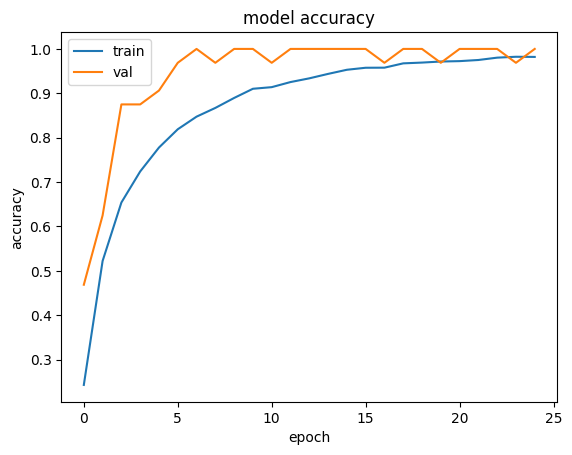

In [17]:
# plot accuracy and loss
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [18]:
model.save('model_avg_25.h5')